In [209]:
import pandas as pd
import numpy as np
from datetime import date, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.axes as ax
import openpyxl
from openpyxl.styles import Border, Side, PatternFill, Font, GradientFill, Alignment
from openpyxl.drawing.image import Image
import win32com.client as win32
import os
from PIL import ImageGrab
import win32com.client

olApp = win32.Dispatch('Outlook.Application')
olNS = olApp.GetNameSpace('MAPI')

import sys
sys.path.append("C:\\Users\\KlimovaAnnaA\\Documents\\MyFiles\\Projects\\OCP")
from Defs import merge_SalesUnits
from Defs import merge_Mapping
from Defs import Period
from Defs import new_list
from Defs import export_from_RISKCUSTOM
from Defs import add_in_currency_column
from Defs import concat_columns
from Defs import export_from_WHWEEK

In [210]:
string = '''
USD/VND
USD/INR
RUB/INR
'''
string_list = string.strip().split('\n')
CCY_df = pd.DataFrame({'CCY':string_list})
CCY_df['CCY_from'] = CCY_df.CCY.str[:3]
CCY_df['CCY_to'] = CCY_df.CCY.str[4:]
CCY_df

,CCY,CCY_from,CCY_to
0,USD/VND,USD,VND
1,USD/INR,USD,INR
2,RUB/INR,RUB,INR


In [211]:
data_CCY_map = pd.read_csv('C:\\Users\\KlimovaAnnaA\\Documents\\MyFiles\\Projects\\OCP\\Методология\\CCY_mapping.csv')
data_CCY_map.head(2)

,id,CCY,CCY_from,CCY_to
0,322,USD/RUB,USD,RUB
1,311,USD/CHF,USD,CHF


In [212]:
data_CCY_map.info()
CCY_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        24 non-null     int64 
 1   CCY       24 non-null     object
 2   CCY_from  24 non-null     object
 3   CCY_to    24 non-null     object
dtypes: int64(1), object(3)
memory usage: 900.0+ bytes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   CCY       3 non-null      object
 1   CCY_from  3 non-null      object
 2   CCY_to    3 non-null      object
dtypes: object(3)
memory usage: 204.0+ bytes


In [213]:
CCY_df['id'] = CCY_df.merge(data_CCY_map, on='CCY', how='left')['id'].fillna(0).astype(int)
CCY_df

,CCY,CCY_from,CCY_to,id
0,USD/VND,USD,VND,0
1,USD/INR,USD,INR,2334
2,RUB/INR,RUB,INR,0


In [214]:
data_USD_RUB = data_CCY_map[(data_CCY_map['CCY_to']=="RUB")&(data_CCY_map['CCY_from']=="USD")]
CCY_df = pd.concat([CCY_df, data_USD_RUB])

In [215]:
query = """
select *
from "RISKACCESS"."XXMR_MADAB_COMMODITIES"
WHERE "PRODUCT_CATEGORY" = 'Exchange Rate'
"""
data_rate = export_from_RISKCUSTOM(query)
find_ccy = 'VND'
find_ccy_data_rate = data_rate.loc[(data_rate['CURRENCY_1']==find_ccy)|(data_rate['CURRENCY_2']==find_ccy), ['ID', 'CURRENCY_1', 'CURRENCY_2']]
find_ccy_data_rate = find_ccy_data_rate.drop_duplicates(subset=['CURRENCY_1', 'CURRENCY_2'])
# data_rate[data_rate.ID ==322]
CCY_df.loc[(CCY_df.CCY_from=='USD')&(CCY_df.CCY_to=='VND'), 'id'] = find_ccy_data_rate.loc[(find_ccy_data_rate.CURRENCY_1=='USD')&(find_ccy_data_rate.CURRENCY_2=='VND'), 'ID'].astype(int).item()
CCY_df

C:\Users\KlimovaAnnaA\Documents\MyFiles\Projects\OCP\Defs.py:98: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data_export = pd.read_sql(query, con=connection)


,CCY,CCY_from,CCY_to,id
0,USD/VND,USD,VND,2358
1,USD/INR,USD,INR,2334
2,RUB/INR,RUB,INR,0
0,USD/RUB,USD,RUB,322


In [216]:
CCY_df.id = CCY_df.id.astype(int)
CCY_id_unique_list = CCY_df['id'].unique().tolist()
CCY_id_unique_list.remove(0)
CCY_id_unique_list

[2358, 2334, 322]

In [217]:
CCY_id_unique_str = str(CCY_id_unique_list)[1:-1]

query = f"""select COMMODITY_ID, PERIOD, VALUE1 from "RISKACCESS"."XXMR_MADAB_CONTENT"
    where "RISKACCESS"."XXMR_MADAB_CONTENT"."COMMODITY_ID" in ({CCY_id_unique_str})
    and "RISKACCESS"."XXMR_MADAB_CONTENT"."PERIOD" >= trunc(sysdate - interval '10' year)"""
data = export_from_RISKCUSTOM(query)

C:\Users\KlimovaAnnaA\Documents\MyFiles\Projects\OCP\Defs.py:98: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data_export = pd.read_sql(query, con=connection)


In [218]:
data.pivot_table(index='COMMODITY_ID', values='PERIOD', aggfunc=[min, max, 'count'])
# data[data.isna().all(axis=1)]
# data[data.duplicated()]

C:\Users\KlimovaAnnaA\AppData\Local\Temp\ipykernel_952\1072063462.py:1: FutureWarning: The provided callable <built-in function min> is currently using DataFrameGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  data.pivot_table(index='COMMODITY_ID', values='PERIOD', aggfunc=[min, max, 'count'])
C:\Users\KlimovaAnnaA\AppData\Local\Temp\ipykernel_952\1072063462.py:1: FutureWarning: The provided callable <built-in function max> is currently using DataFrameGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  data.pivot_table(index='COMMODITY_ID', values='PERIOD', aggfunc=[min, max, 'count'])


,min,max,count
,PERIOD,PERIOD,PERIOD
COMMODITY_ID,,,
322,2014-08-08,2024-08-21,3629
2334,2014-08-08,2024-08-22,3630
2358,2014-08-08,2024-08-22,3629


In [219]:
data_work = data[:]
data_work['CCY'] = data_work.merge(CCY_df.drop_duplicates(), left_on ='COMMODITY_ID' , right_on='id', how='left')['CCY']

# cross rate
data_work_cross = data_work[data_work.CCY=='USD/RUB'].merge(data_work[data_work.CCY=='USD/INR'], how='inner', on='PERIOD')
data_work_cross['CCY'] = 'RUB/INR'
data_work_cross['VALUE1'] = (1/data_work_cross.VALUE1_x)*data_work_cross.VALUE1_y
data_work_cross = data_work_cross[['PERIOD', 'CCY','VALUE1']]
data_work = pd.concat([data_work,data_work_cross])
data_work.head(2)

C:\Users\KlimovaAnnaA\AppData\Local\Temp\ipykernel_952\3575844762.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_work['CCY'] = data_work.merge(CCY_df.drop_duplicates(), left_on ='COMMODITY_ID' , right_on='id', how='left')['CCY']


,COMMODITY_ID,PERIOD,VALUE1,CCY
0,322.0,2014-08-08,36.2266,USD/RUB
1,322.0,2014-08-09,36.2266,USD/RUB


In [220]:
data_work['pct_change'] = data_work.groupby('CCY').VALUE1.transform(lambda x: x.pct_change()).fillna(0)
data_work = data_work.sort_values(['CCY','PERIOD'], ascending=False)
data_work.head()

,COMMODITY_ID,PERIOD,VALUE1,CCY,pct_change
10887,2358.0,2024-08-22,25149.0,USD/VND,0.0
10886,2358.0,2024-08-21,25149.0,USD/VND,0.0
10885,2358.0,2024-08-20,25149.0,USD/VND,0.0
10884,2358.0,2024-08-19,25149.0,USD/VND,0.0
10883,2358.0,2024-08-18,25149.0,USD/VND,0.0


In [227]:
df_list = []
for CCY in data_work.CCY.unique().tolist():
    df_dict_string = {}
    df_dict_string['CCY'] = CCY
    product_df = data_work[data_work.CCY==CCY]
    y=252
    y3=252*3
    y5=252*5
    for window in [y, y3, y5, len(product_df)]:
        Vol = 0
        data_window = product_df.iloc[:window,:]
        # data_window['roll_change'] = data_window.VALUE1.pct_change()
        Vol = data_window['pct_change'].std()*100
        if window == y:
            df_dict_string['Vol_1_year'] = Vol
        elif window == y3:
            df_dict_string['Vol_3_year'] = Vol
        elif window == y5:
            df_dict_string['Vol_5_year'] = Vol
        else:
            df_dict_string['Vol_all'] = Vol
    df_list.append(df_dict_string)


In [228]:
vol_df = pd.DataFrame(df_list)
vol_df

,CCY,Vol_1_year,Vol_3_year,Vol_5_year,Vol_all
0,USD/VND,0.352251,0.310280,0.247618,0.162963
1,USD/RUB,0.794686,1.442127,1.778915,1.355496
2,USD/INR,0.101477,0.243384,0.262984,0.284150
3,RUB/INR,0.778545,1.615447,1.823833,1.368254


In [223]:

# data_work
check = data_work[data_work.CCY =='USD/RUB'].iloc[:356,:]
check['roll'] = check.VALUE1.pct_change()
check['roll_mean'] = check.roll.rolling(355).std()
check

,COMMODITY_ID,PERIOD,VALUE1,CCY,pct_change,roll,roll_mean
3627,322.0,2024-08-21,85.7749,USD/RUB,0.000000,NaN,NaN
3626,322.0,2024-08-20,85.7749,USD/RUB,0.000000,0.000000,NaN
3625,322.0,2024-08-19,85.7749,USD/RUB,0.000000,0.000000,NaN
3624,322.0,2024-08-18,85.7749,USD/RUB,0.000000,0.000000,NaN
3623,322.0,2024-08-17,85.7749,USD/RUB,0.000000,0.000000,NaN
...,...,...,...,...,...,...,...
3276,322.0,2023-09-05,97.5709,USD/RUB,0.011578,-0.005661,NaN
3275,322.0,2023-09-04,96.4542,USD/RUB,0.001257,-0.011445,NaN
3274,322.0,2023-09-03,96.3331,USD/RUB,0.000000,-0.001256,NaN
3273,322.0,2023-09-02,96.3331,USD/RUB,0.000000,0.000000,NaN


In [224]:
check.roll.std()

np.float64(0.007733477047809842)

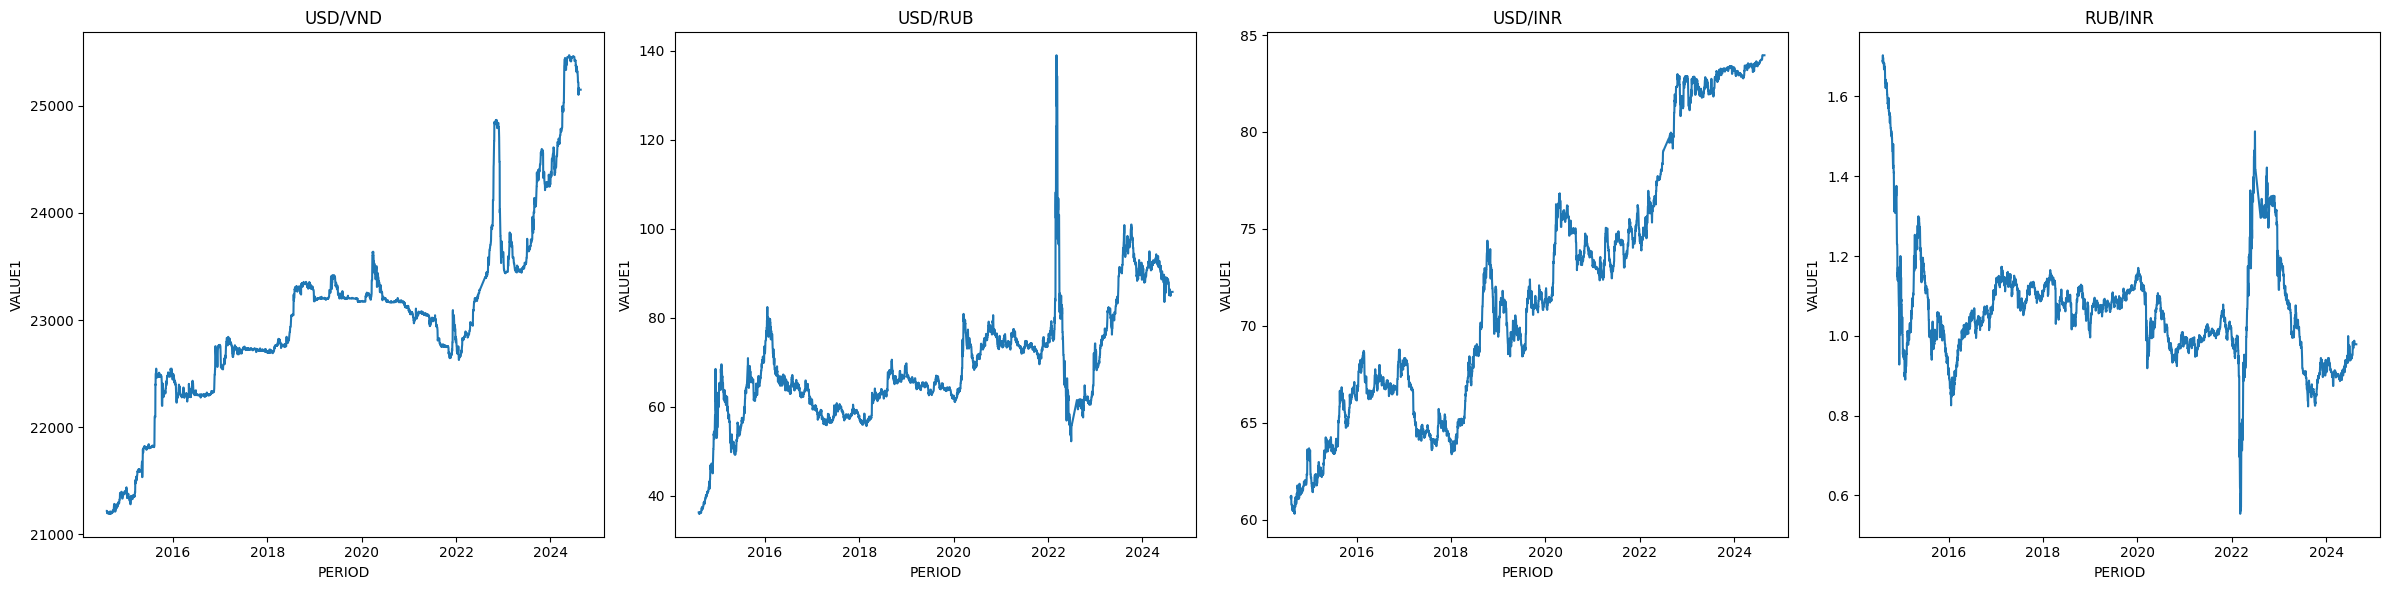

In [225]:
# data_work['VALUE1_log'] = np.log10(data_work.VALUE1)
CCY_list = data_work.CCY.unique().tolist()
fig, axes = plt.subplots(ncols=len(CCY_list), figsize=(24,6))
counter=0
for CCY in CCY_list:
    sns.lineplot(data_work[data_work.CCY==CCY],x='PERIOD', y='VALUE1',  ax=axes[counter])
    axes[counter].set_title(CCY)
    counter+=1
plt.tight_layout()
plt.savefig('Price.png')

In [229]:


Oui_file = f'{str(date.today())}_CCY_volatility.xlsx'
writer = pd.ExcelWriter(Oui_file, engine='openpyxl')

vol_df.to_excel(writer, sheet_name='CCY_Volatility')

worksheet = writer.sheets['CCY_Volatility']
img = openpyxl.drawing.image.Image(f'Price.png')
img.anchor = 'H3'
worksheet.add_image(img)

data_work.to_excel(writer, sheet_name='data')

writer.close()
